# TRUSTWORTHY AI: Diversity, Non-discrimination and Fairness Requirement 

#### Script to ensure the Diversity, Non-discrimination and Fairness requirement for a dataset. Based on EU guidelines.
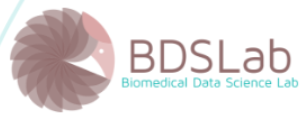



## TABLE OF CONTENTS:

<div class="alert" style="margin-top: 20px">

1. [Data preparation](#data-preparation)<br>
1.1. [Data pre-processing](#data-pre-processing)<br>

2. [Model Development](#model-development)<br>
2.1. [Design & Training](#design-training)<br>
2.1.1. [Obviate the existence of biasess](#obviate-bias)<br>
2.1.2. [Reweighting](#reweighting)<br>
2.1.3. [Oversampling](#oversampling)<br>
2.2. [Evaluation](#evaluation)<br>

3. [Deployment & Use](#deployment-use)<br>
3.1. [Predictions](#predictions)<br>
3.2. [Anomaly monitoring](#anomaly-monitoring)<br>

[References](#references)

</div>


The requirement is linked to fairness. It's about enabling inclusion and diversity throughout the lifecycle of the model. This covers three main concepts:

* **Avoidance of unfair bias:** identify and remove any discriminatory bias to avoid unintentional bias and discrimination.
*  **Accesibility and universal design:** making systems user-centred and accessible to all people, regardless of their background and particular condition.
*  **Stakeholder participation:**  consultation and feedback with stakeholders who may be affected.

We start by preparing the working environment. Import all the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.subplots as sp

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTENC

import seaborn as sns
import itertools
import shap

from functions.NaiveBayesMixed import NaiveBayesMixed
from functions.handleData import handleData

Load the dataset and define Metadata

In [2]:
path = 'C:\\Users\\carlo\\OneDrive - UPV\\ESCRITORIO CARLOS\\UPV\\BECA COLABORACIÓN\\Datasets\\Diabetes\\' 
file_name = 'dataset_train_diabetes_QC.csv'
data = pd.read_csv(path + file_name)

# Create a subset to work more efficiently
# data = data.sample(frac = 1, random_state=100) 

In [3]:
# Define Metadata
dataset = data
output = "readmitted"
positive_class = "<30"
feat_id = ["encounter_id","patient_nbr"]
feat_sensitive = ["race","gender"]
feat_types = {
    "race": "categorical",
    "gender": "categorical",
    "age": "numerical",
    # "weight": "categorical",
    "admission_type": "categorical",
    "discharge_disposition": "categorical",
    "admission_source": "categorical",
    "time_in_hospital": "numerical",
    # "payer_code": "categorical",
    # "medical_specialty": "categorical",
    "num_lab_procedures":"numerical",
    "num_procedures":"numerical",
    "num_medications":"numerical",
    "number_outpatient":"numerical",
    "number_emergency":"numerical",
    "number_inpatient":"numerical",
    "diag_1": "categorical",
    "diag_2": "categorical",
    "diag_3": "categorical",
    "number_diagnoses": "numerical",
    "change": "categorical", 
    "diabetesMed": "categorical",
}
feat2balance = ["race"]
data_provenance = "A Health Facts database that represents 10 years (1999-2008) of clininical care at 130 hospitals in United States."

In [4]:
### Uncomment only if you want to binarise a multi-class classification problem ###
# if positive_class:
#     dataset[output] = pd.Series(np.where(dataset[output] == positive_class, 1, 0), index=dataset[output].index, name=output)

# Divide in features and tags
features_df = dataset.drop(output,axis=1) # Delete tags
tags_df = dataset[output] # Select just the tags

unique_classes = np.unique(tags_df)
n_classes = len(unique_classes)
feat_num = [col for col, type in feat_types.items() if type == "numerical"]
feat_cat = [col for col, type in feat_types.items() if type == "categorical"]
feature_names = features_df.columns

handleData = handleData(feat_num, feat_cat)

## 1. DATA PREPARATION  <a class="anchor" id="data-preparation"></a>

### 1.1. Data Pre-processing: <a class="anchor" id="data-pre-processing"></a>

Ideally, it would be necessary to have homogeneous groups to ensure fairness and to avoid metric preferences through majority groups. To identify possible biases, it is important to look at the category distributions by sensitive variable and class (`Sensitive exploratoy analysis`)

In case of imbalance between classes, we develop three workflows to differentiate the model behaviour: with the possible bias implicit, oversampling in one feature to balance the distributions, or applying reweighting to equalise the predictive power regardless of its distributions (`Pre-processing & In-processing bias mitigation`)

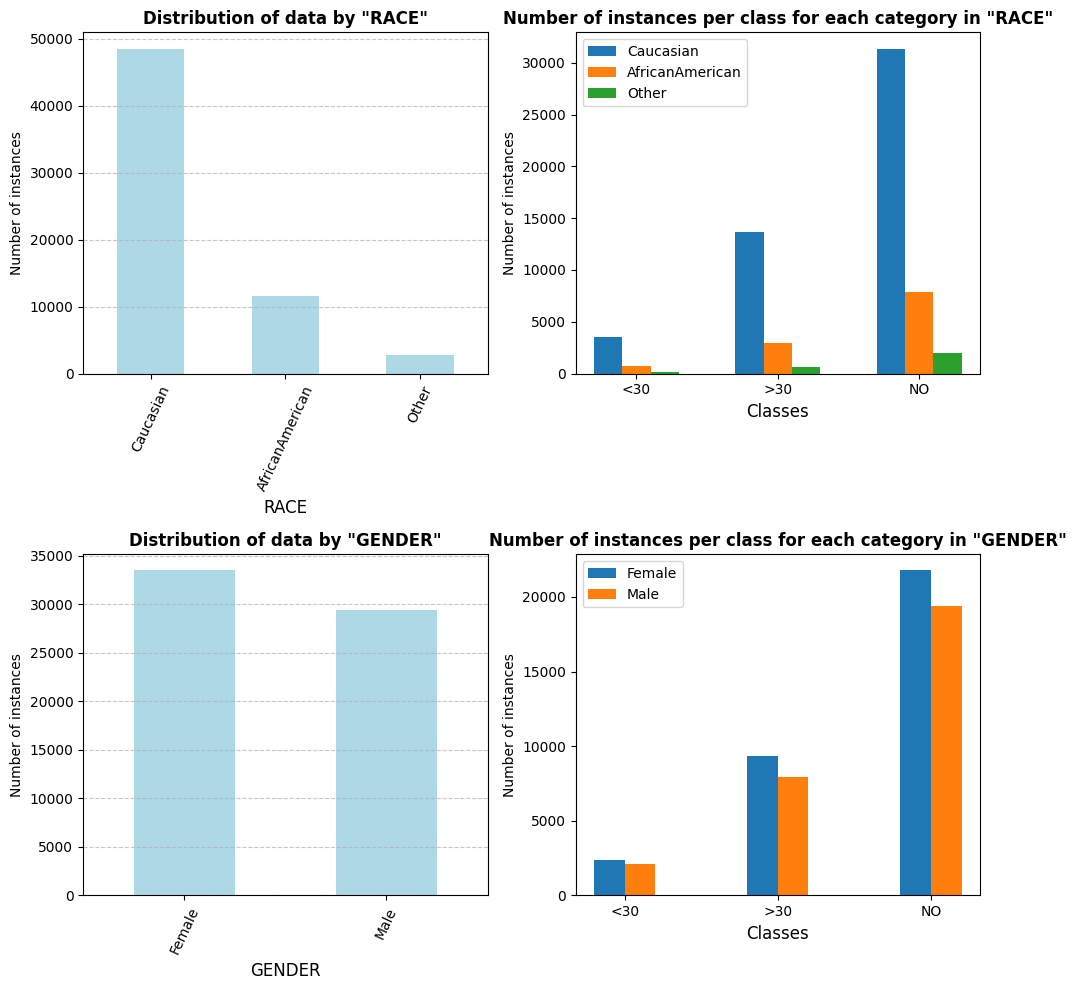

In [5]:
n_sensitive = len(feat_sensitive)
fig, axes = plt.subplots(2, n_sensitive, figsize=(10, 5 * n_sensitive))

if n_sensitive == 1:
    axes = axes.reshape(1, -1)  # Switch to a two-dimensional single-row matrix

for i, sensitive in enumerate(feat_sensitive):
    sensitive_counts = features_df[sensitive].value_counts()
    unique_categories = sensitive_counts.index

    ax = axes[i, 0]
    sensitive_counts.plot(kind='bar', ax=ax, color='lightblue')
    ax.set_xlabel(sensitive.upper(), fontsize=12)
    ax.set_ylabel(f'Number of instances', fontsize=10)
    ax.set_title(f'Distribution of data by "{sensitive.upper()}"', fontsize=12, weight='bold')
    ax.tick_params(axis='x', labelrotation=65, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Count the number of people per class for each category
    ax = axes[i, 1]
    count_cat = {}
    for category in unique_categories:
        tags_cat = tags_df[features_df[sensitive] == category].squeeze()
        counts_per_class = [np.sum(tags_cat == cls) for cls in unique_classes]
        count_cat[category] = counts_per_class

    bar_width = 0.2
    x = np.arange(len(unique_classes))
    for j, category in enumerate(unique_categories):
        ax.bar(x + j * bar_width, count_cat[category], width=bar_width, label=category)

    ax.set_xlabel('Classes', fontsize=12)
    ax.set_xticks(x + (len(unique_categories) - 1) * bar_width / 2)
    ax.set_xticklabels(unique_classes)
    ax.set_ylabel('Number of instances', fontsize=10)
    ax.legend(unique_categories, prop={'size': 10})
    ax.set_title(f'Number of instances per class for each category in "{sensitive.upper()}"', fontsize=12, weight='bold')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

To identify any bias in data collection, you could perform a missing value analysis by sensitive characteristics.

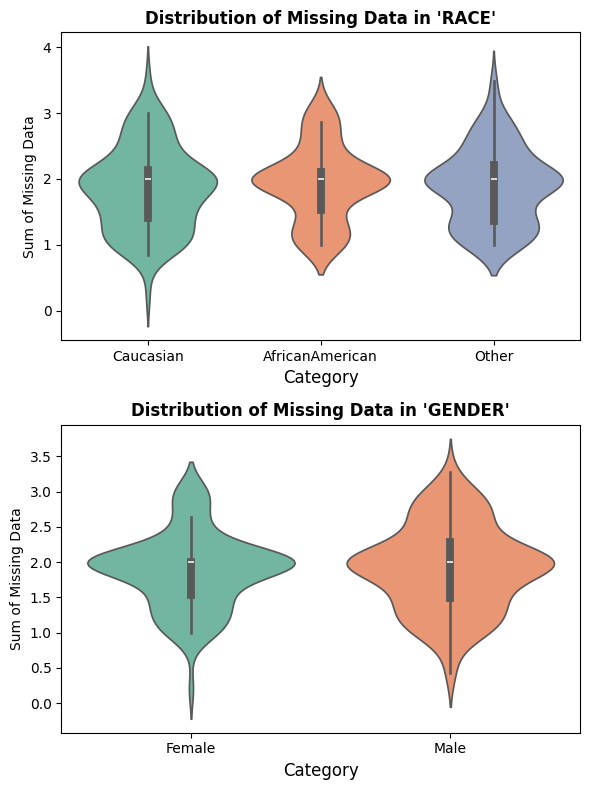

In [6]:
file_name = 'missing_array.csv'
missing_array = pd.read_csv(path + file_name)
fig, axes = plt.subplots(n_sensitive, 1, figsize=(6, 4 * n_sensitive))

num_points = 100

for i, sensitive in enumerate(feat_sensitive):
    unique_categories = missing_array[sensitive].unique()

    data = pd.DataFrame()

    # Calculate sum of missing data by category
    for cat in unique_categories:
        subset = missing_array[missing_array[sensitive] == cat]
        missing_sum = subset.drop(columns=feat_sensitive).sum(axis=1)

        if not missing_sum.empty:
            x_interp = np.linspace(0, 1, num_points)
            y_interp = np.interp(x_interp, np.linspace(0, 1, len(missing_sum)), missing_sum)
            data[cat] = y_interp

    if n_sensitive == 1:
        ax = sns.violinplot(data=data, ax=axes, palette='Set2')
    else:
        ax = sns.violinplot(data=data, ax=axes[i], palette='Set2')

    ax.set_xlabel("Category", fontsize=12)
    ax.set_ylabel("Sum of Missing Data", fontsize=10)
    ax.set_title(f"Distribution of Missing Data in '{sensitive.upper()}'", fontsize=12, weight='bold')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()


In order to show possible differences under each sensitive variable, we plot a correlation matrix heat map for each category of each sensitive variable.

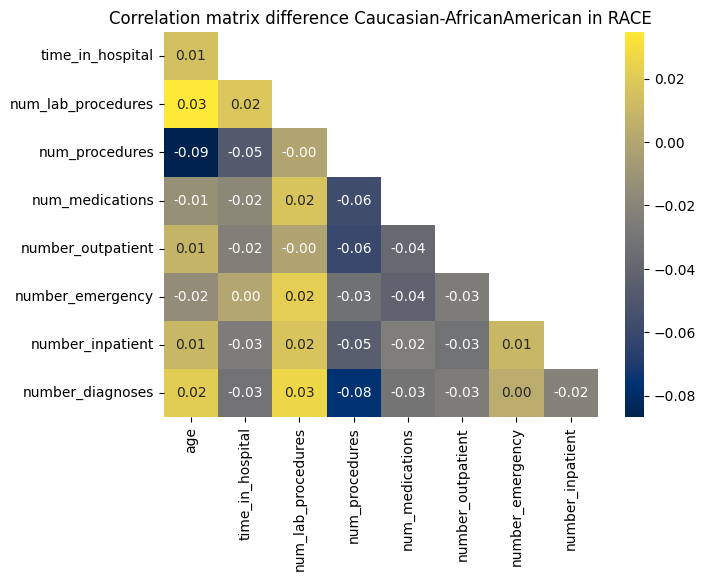

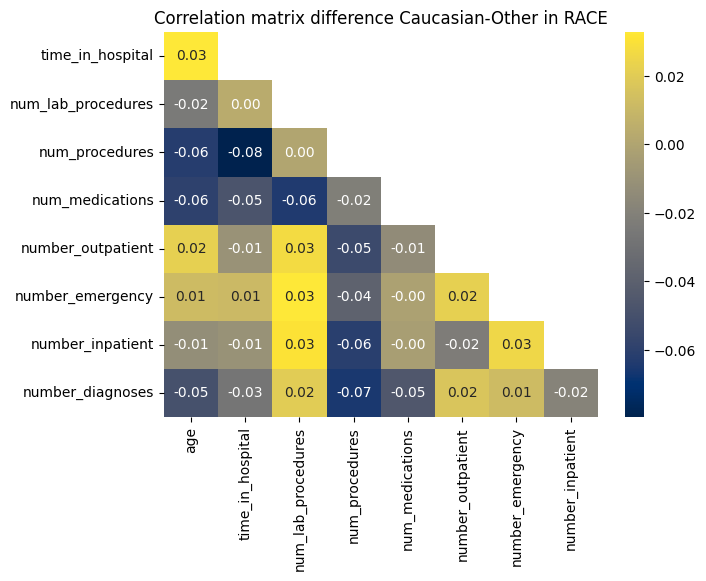

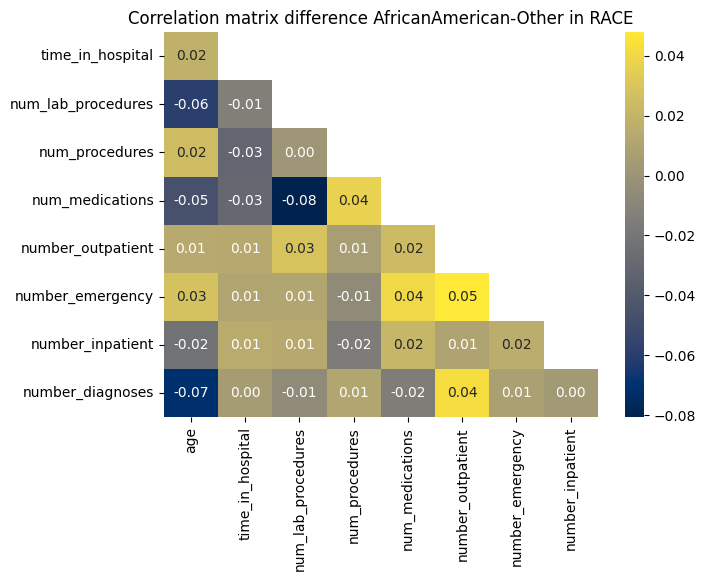

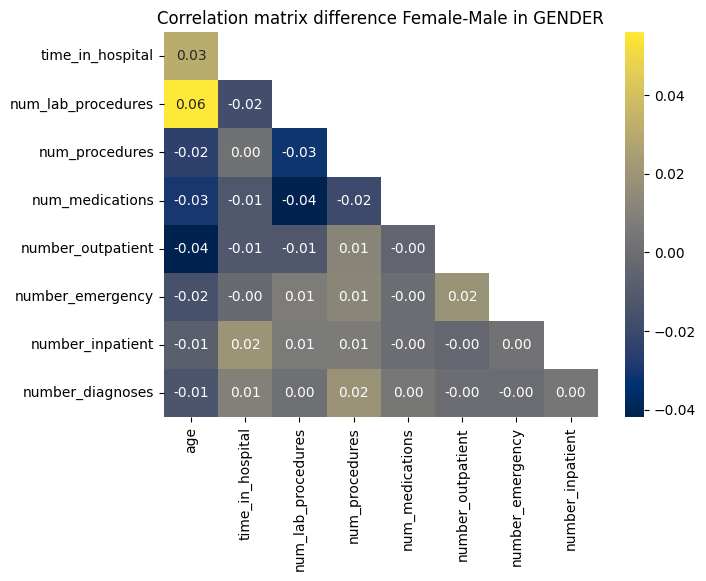

In [7]:
data_num = features_df[feat_num]

for sensitive in feat_sensitive:
    category_sensitive = pd.unique(features_df[sensitive])
    combinations = list(itertools.combinations(category_sensitive, 2))
    
    for category_pair in combinations:
        category1, category2 = category_pair
        
        # Calculate numerical correlation matrix
        corr_num_1 = data_num[features_df[sensitive] == category1].corr()
        corr_num_2 = data_num[features_df[sensitive] == category2].corr()
        
        # Calculate the difference between correlation matrices
        diff_corr = corr_num_1 - corr_num_2
        mask = np.triu(np.ones_like(corr_num_1, dtype=bool)) # A mask to hide the upper right part of the matrix (it is duplicated)

        # Plot only if there is a difference of 0.25 between the two categories.
        if any(np.abs(diff_corr.values[mask]) > 0.05):
            plt.figure(figsize=(7, 5))
            sns.heatmap(diff_corr.iloc[1:, :-1], mask=mask[1:, :-1], annot=True, fmt=".2f", cmap="cividis")
            plt.title(f'Correlation matrix difference {category1}-{category2} in {sensitive.upper()}', fontsize=12)
            plt.show()

## 2. MODEL DEVELOPMENT <a class="anchor" id="model-development"></a>
### 2.1. Design & Training  <a class="anchor" id="design-training"></a>

#### 2.1.1. Obviate the existence of biasess: <a class="anchor" id="obviate-bias"></a>
In this case, the training of the models is independent of the presence of unbalance.

In [8]:
features_df_encoded, feature_names_encoded, feat_cat_encoded = handleData.encode(features_df)

# Encode Tags 
if not np.issubdtype(tags_df.dtype, np.number):
    encoderLabel = LabelEncoder()
    tags_df_encoded = encoderLabel.fit_transform(tags_df)
    tags_df_encoded = pd.Series(tags_df_encoded, index=tags_df.index, name=tags_df.name)

    tags_df_mapping = {label: code for code, label in enumerate(encoderLabel.classes_)} # Dictionary with the code reference for each class
    unique_classes_enc = np.unique(tags_df_encoded)
    print('Dictionary of tags: ', tags_df_mapping)
else:
    tags_df_encoded, unique_classes_enc  = tags_df, unique_classes

feat_train, feat_test, tags_train, tags_test = train_test_split(features_df_encoded, tags_df_encoded, test_size=0.2, random_state = 1)


Dictionary of tags:  {'<30': 0, '>30': 1, 'NO': 2}


In [9]:
model_RandomForest_1 = RandomForestClassifier(n_estimators=100)
model_MixedNB_1 = NaiveBayesMixed(feat_num, feat_cat_encoded)

classifiers_nothing = {'RF': model_RandomForest_1, 'NB': model_MixedNB_1}

for classifier_name, classifier in classifiers_nothing.items():

    classifier.fit(feat_train, tags_train) 
    tags_pred = classifier.predict(feat_test)

    print(f"{classifier_name} (nothing) Classification report")
    print(classification_report(tags_test, tags_pred))

RF (nothing) Classification report
              precision    recall  f1-score   support

           0       0.33      0.00      0.01       918
           1       0.46      0.18      0.25      3473
           2       0.68      0.93      0.79      8187

    accuracy                           0.66     12578
   macro avg       0.49      0.37      0.35     12578
weighted avg       0.59      0.66      0.58     12578

NB (nothing) Classification report
              precision    recall  f1-score   support

           0       0.20      0.01      0.02       918
           1       0.41      0.22      0.28      3473
           2       0.68      0.89      0.77      8187

    accuracy                           0.64     12578
   macro avg       0.43      0.37      0.36     12578
weighted avg       0.57      0.64      0.58     12578



#### 2.1.2. Reweighting: <a class="anchor" id="reweighting"></a>

This procedure involves finding those weights of an original distribution that make the distributions of one or more variables equal [1]. 

In [10]:
sample_weights_train = compute_sample_weight(class_weight='balanced', y=features_df.loc[feat_train.index, feat2balance])

model_RandomForest_2 = RandomForestClassifier(n_estimators=100)
model_MixedNB_2 = NaiveBayesMixed(feat_num, feat_cat_encoded)

classifiers_reweighting = {'RF': model_RandomForest_2, 'NB': model_MixedNB_2}

for classifier_name, classifier in classifiers_reweighting.items():

    classifier.fit(feat_train, tags_train, sample_weight=sample_weights_train) 
    tags_pred = classifier.predict(feat_test)

    print(f"{classifier_name} (reweighting) Classification report")
    print(classification_report(tags_test, tags_pred))

RF (reweighting) Classification report
              precision    recall  f1-score   support

           0       0.45      0.01      0.01       918
           1       0.47      0.17      0.24      3473
           2       0.68      0.94      0.79      8187

    accuracy                           0.66     12578
   macro avg       0.53      0.37      0.35     12578
weighted avg       0.60      0.66      0.58     12578

NB (reweighting) Classification report
              precision    recall  f1-score   support

           0       0.19      0.02      0.03       918
           1       0.40      0.23      0.30      3473
           2       0.68      0.87      0.77      8187

    accuracy                           0.64     12578
   macro avg       0.42      0.37      0.36     12578
weighted avg       0.57      0.64      0.58     12578



#### 2.1.3. Oversampling: <a class="anchor" id="oversampling"></a>

Based on the existing data, new instances are created with the aim of equalising the number of samples of each category for a given sensitive feature. The method used is SMOTENC, an extension of SMOTE to deal with continuous and categorical data [2, 3].

In [11]:
feat_train_decoded = handleData.decode(feat_train)
data2balance = pd.concat([feat_train_decoded, tags_train], axis=1)
data2balance.drop(feat2balance, axis=1, inplace=True)

In [12]:
feat_cat_balance = [feat for feat in feat_cat if feat != feat2balance[0]] + [output]

# Apply SMOTENC only to the categorical variable you want to balance.
smotenc = SMOTENC(categorical_features=feat_cat_balance, random_state=1)
data_balanced, category_balanced = smotenc.fit_resample(data2balance, feat_train_decoded[feat2balance])

feat2balance_idx = feat_train_decoded.columns.tolist().index(feat2balance[0])

feat_train_over = data_balanced.iloc[:, :-1]
feat_train_over.insert(feat2balance_idx, feat2balance[0], category_balanced)
tags_train_over = data_balanced.iloc[:,-1]

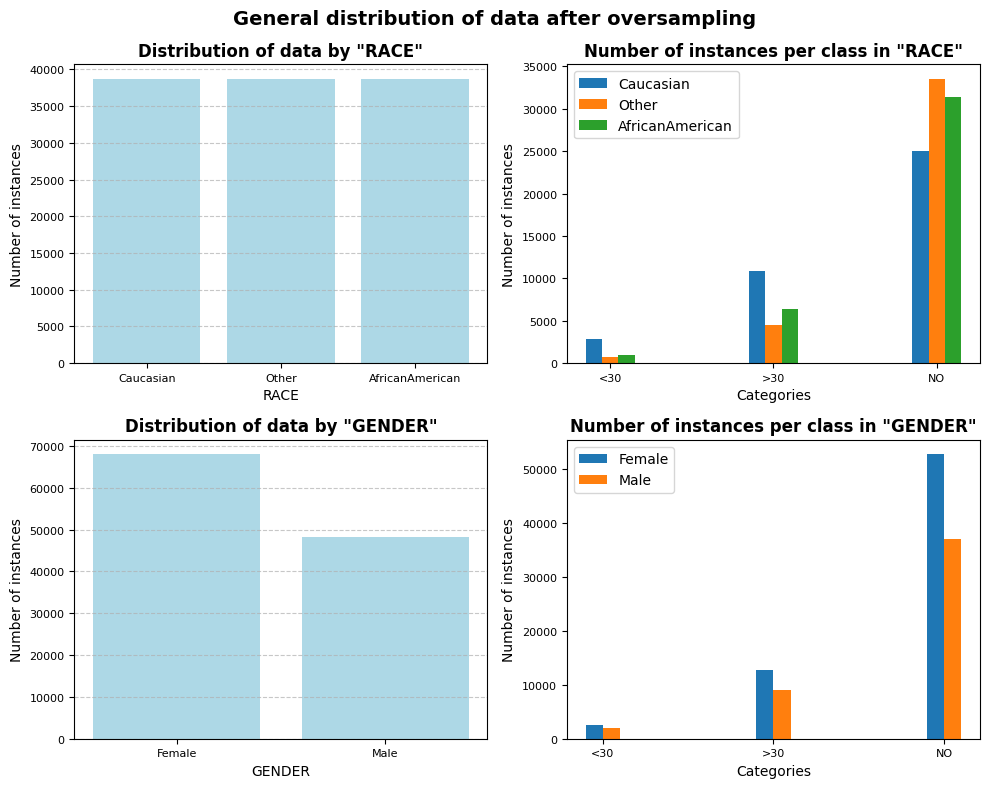

In [13]:
fig, axes = plt.subplots(n_sensitive, 2, figsize=(10, 4 * n_sensitive))
fig.suptitle('General distribution of data after oversampling', fontsize=14, weight='bold')

if n_sensitive == 1:
    axes = axes.reshape(1, -1)  

for i, sensitive in enumerate(feat_sensitive):
    # Obtain tags and quantities
    sensitive_counts = feat_train_over[sensitive].value_counts()
    unique_categories = sensitive_counts.index
    n_values = sensitive_counts.values

    ax = axes[i, 0]
    ax.bar(unique_categories, n_values, color='lightblue')
    ax.set_xlabel(sensitive.upper(), fontsize=10)
    ax.set_ylabel(f'Number of instances', fontsize=10)
    ax.set_title(f'Distribution of data by "{sensitive.upper()}"', fontsize=12, weight='bold')
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Count the number of people per class for each category
    count_cat = {}
    for category in unique_categories:
        tags_cat = tags_train_over[feat_train_over[sensitive] == category].squeeze()
        for classes in unique_classes_enc:
            category_count = (tags_cat == classes).sum()
            count_cat[(category, classes)] = category_count

    count_x_cat = {category: [count_cat.get((category, classes), 0) for classes in unique_classes_enc] for category in unique_categories}

    ax = axes[i, 1]
    bar_width = 0.1
    x = list(range(len(unique_classes)))
    for j, category in enumerate(unique_categories):
        y_values = count_x_cat[category]
        x_positions = [pos + j * bar_width for pos in x]
        ax.bar(x=x_positions, height=y_values, width=bar_width, label=category)
    
    ax.set_xlabel('Categories', fontsize=10)
    ax.set_xticks([pos + (len(unique_categories) - 1) * bar_width / 2 for pos in x])
    ax.set_xticklabels(unique_classes)
    ax.set_ylabel('Number of instances', fontsize=10)
    ax.legend(unique_categories,  prop={'size':10})
    ax.set_title(f'Number of instances per class in "{sensitive.upper()}"', fontsize=12, weight='bold')
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()


In [14]:
feat_train_over_encoded, _, _ = handleData.encode(feat_train_over)

model_RandomForest_3 = RandomForestClassifier(n_estimators=100)
model_MixedNB_3 = NaiveBayesMixed(feat_num, feat_cat_encoded)

classifiers_oversampling = {'RF': model_RandomForest_3, 'NB': model_MixedNB_3}

for classifier_name, classifier in classifiers_oversampling.items():

    classifier.fit(feat_train_over_encoded, tags_train_over) 
    tags_pred = classifier.predict(feat_test)

    print(f"{classifier_name} (oversampling) Classification report")
    print(classification_report(tags_test, tags_pred))

RF (oversampling) Classification report
              precision    recall  f1-score   support

           0       0.25      0.00      0.01       918
           1       0.45      0.14      0.22      3473
           2       0.67      0.94      0.79      8187

    accuracy                           0.65     12578
   macro avg       0.46      0.36      0.34     12578
weighted avg       0.58      0.65      0.57     12578

NB (oversampling) Classification report
              precision    recall  f1-score   support

           0       0.16      0.03      0.05       918
           1       0.38      0.26      0.31      3473
           2       0.69      0.84      0.76      8187

    accuracy                           0.62     12578
   macro avg       0.41      0.38      0.37     12578
weighted avg       0.56      0.62      0.58     12578



### 2.2. Evaluation  <a class="anchor" id="evaluation"></a>

If there is a bias due to the sensitive feature indicated, some differences in model performance will be seen when looking at their ROC curves.

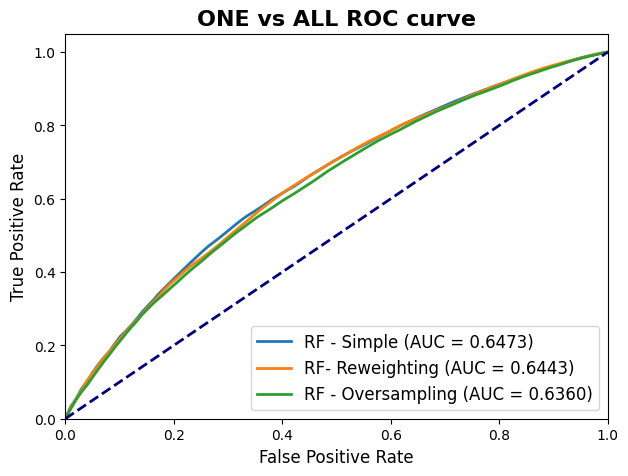

In [15]:
classifiers = {'RF - Simple': model_RandomForest_1,
               'RF- Reweighting': model_RandomForest_2,
              'RF - Oversampling': model_RandomForest_3}

k_folds = 5
plt.figure(figsize=(7, 5))

for classifier_name, classifier in classifiers.items():
    tpr_list = []
    mean_fpr = np.linspace(0, 1, 100)  # Common set of points

    y_scores = classifier.predict_proba(feat_test)

    if n_classes > 2:

        # Binarise tags one-vs-all
        tags_test_binarized = label_binarize(tags_test, classes=unique_classes_enc)
        n_classes = tags_test_binarized.shape[1]
        
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(tags_test_binarized[:, i], y_scores[:, i])
            
            # Interpolate the ROC curve to have a common set of points
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0  # Set the first point to (0, 0)
            tpr_list.append(interp_tpr)
        
        # Calculate the average ROC curve
        mean_tpr= np.mean(tpr_list, axis=0)
        roc_auc_mean = auc(mean_fpr, mean_tpr)
        
        plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{classifier_name} (AUC = {roc_auc_mean:.4f})')
        
    else:
        fpr, tpr, _ = roc_curve(tags_test, y_scores[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{classifier_name} (AUC = {roc_auc:.4f})')
            
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontdict={'fontsize':12})
plt.ylabel('True Positive Rate', fontdict={'fontsize':12})
plt.title('ONE vs ALL ROC curve', fontdict={'fontsize':16, 'weight': 'bold'})
plt.legend(loc="lower right", prop={'size':12})
plt.show()

It may be interesting to calculate the ROC curve of each sensitive feature to detect possible bias (`Sensitive variables performance`). This plot allows the predictions for each subgroup to be compared.

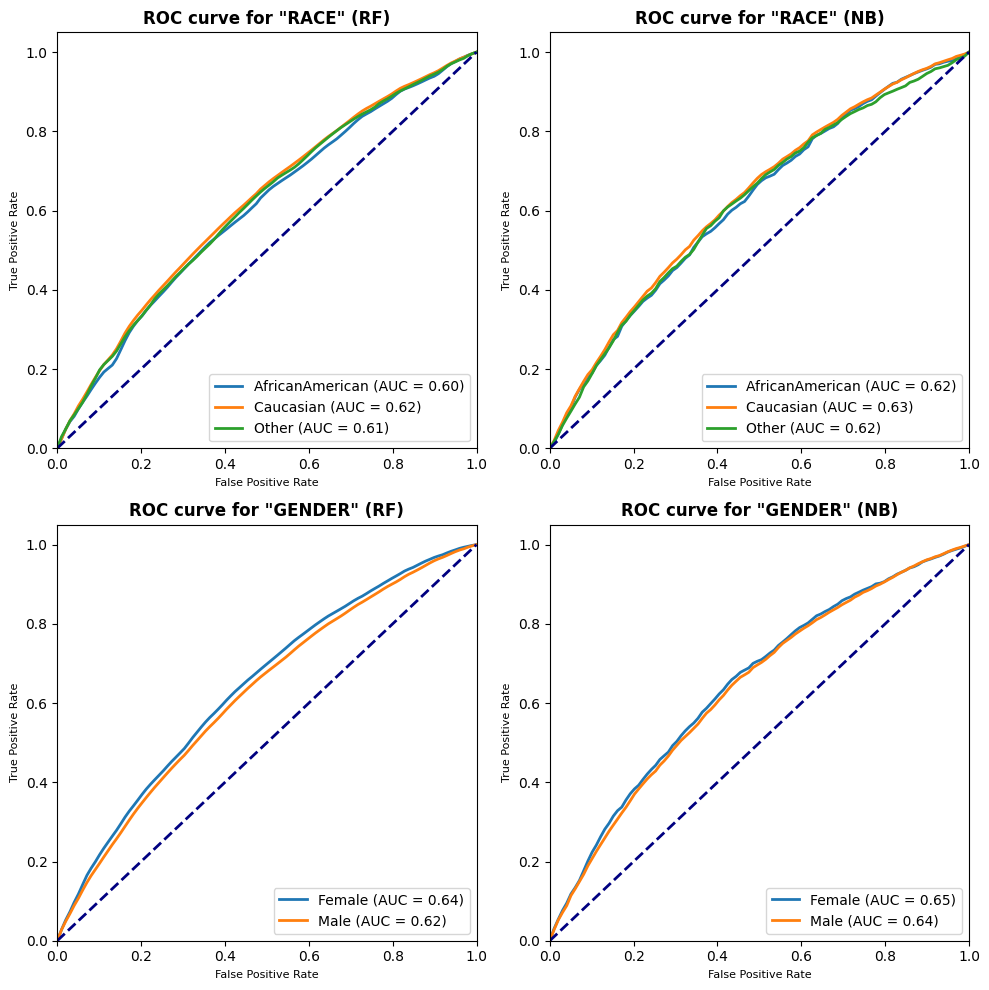

In [16]:
k_folds = 5
fig, axs = plt.subplots(n_sensitive, 2, figsize=(10, 5 * n_sensitive))

for col, (classifier_name, classifier) in enumerate(classifiers_nothing.items()):
    for row, column in enumerate(feat_sensitive):
        # Initialize lists to store the results
        tpr_list_sens = []
        roc_auc_list_sens = []
        fpr_mean = np.linspace(0, 1, 100)  # Common set of points

        unique_categories = np.unique(dataset[column])
        
        # Iterate over each one-hot encoded column
        for cat_col in feature_names_encoded:
            if column in cat_col:  # Check if the column name contains the sensitive feature name
                feat_test_cat = feat_test[feat_test[cat_col] == 1]
                tags_test_cat = tags_test[feat_test[cat_col] == 1]

                if len(tags_test_cat) < k_folds:
                    print(f'The current category in "{column}" does not cover the minimum number of samples for the selected folds.')
                else:
                    tags_test_binarized = label_binarize(tags_test_cat, classes=unique_classes_enc)
                    y_scores_sens = cross_val_predict(classifier, feat_test_cat, tags_test_cat, cv=k_folds, method='predict_proba')

                    if y_scores_sens.shape[1] < len(unique_classes):
                        print(f'The current category in "{column}" does not cover all classes.')
                    else:
                        # Calculate ROC curve and ROC area (AUC) for each class
                        for i in range(len(unique_classes)):
                            fpr, tpr, _ = roc_curve(tags_test_binarized[:, i], y_scores_sens[:, i])
                            interp_tpr = np.interp(fpr_mean, fpr, tpr)
                            interp_tpr[0] = 0.0
                            tpr_list_sens.append(interp_tpr)
                            roc_auc = auc(fpr, tpr)
                            roc_auc_list_sens.append(roc_auc)

                        # Average of TP and FP rates for all the classes
                        tpr_mean = np.mean(tpr_list_sens, axis=0)
                        roc_auc_mean = auc(fpr_mean, tpr_mean)
                        axs[row, col].plot(fpr_mean, tpr_mean, lw=2, label=f'{cat_col.split("_")[-1]} (AUC = {roc_auc_mean:.2f})')

        axs[row, col].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[row, col].set_xlim([0.0, 1.0])
        axs[row, col].set_ylim([0.0, 1.05])
        axs[row, col].set_xlabel('False Positive Rate', fontdict={'fontsize':8})
        axs[row, col].set_ylabel('True Positive Rate', fontdict={'fontsize':8})
        axs[row, col].set_title(f'ROC curve for "{column.upper()}" ({classifier_name})', fontdict={'fontsize':12, 'weight': 'bold'})
        axs[row, col].legend(loc="lower right", prop={'size':10})

plt.tight_layout()
plt.show()

You can also train a model for each category on sensitive features to see the differences in the internal mechanisms that ultimately determine their feature importance in predictions.

In [17]:
models_sensitive = {}

for feat_sens in feat_sensitive:
    unique_categories = pd.unique(dataset[feat_sens])
    models_per_feature = {}
    print(f"Global F1-score in {feat_sens.upper()}:")

    for cat in unique_categories:
        for feat_enc in feature_names_encoded:
            name_encoded = feat_sens + '_' + cat

            if feat_enc == name_encoded:

                feat_train_cat = feat_train[feat_train[feat_enc] == 1]
                tags_train_cat = tags_train[feat_train[feat_enc] == 1]
                feat_test_cat = feat_test[feat_test[feat_enc] == 1]
                tags_test_cat = tags_test[feat_test[feat_enc] == 1]
                
                model_RandomForest = RandomForestClassifier(n_estimators=100)
                model_RandomForest.fit(feat_train_cat, tags_train_cat)
                
                tags_pred_cat = model_RandomForest.predict(feat_test_cat)

                f1_result = f1_score(tags_test_cat, tags_pred_cat, average='weighted')
                print(f"'{cat}' : {f1_result * 100:.2f}%")
                
                models_per_feature[cat] = model_RandomForest
                
    models_sensitive[feat_sens] = models_per_feature

Global F1-score in RACE:
'Caucasian' : 58.57%
'AfricanAmerican' : 57.05%
'Other' : 61.63%
Global F1-score in GENDER:
'Female' : 58.62%
'Male' : 58.01%


## 3. DEPLOYMENT & USE  <a class="anchor" id="deployment-use"></a>

### 3.1. Predictions  <a class="anchor" id="predictions"></a>

In [18]:
file_name = 'dataset_test_diabetes_QC.csv'
data_test = pd.read_csv(path + file_name)

feat_test = data_test.drop(output,axis=1)
tags_test = data_test[output] 

feat_test, _, _ = handleData.encode(feat_test)

# Encode Tags 
if not np.issubdtype(tags_test.dtype, np.number):
    tags_test_encoded = encoderLabel.transform(tags_test)
    tags_test = pd.Series(tags_test_encoded, index=tags_test.index, name=tags_test.name)

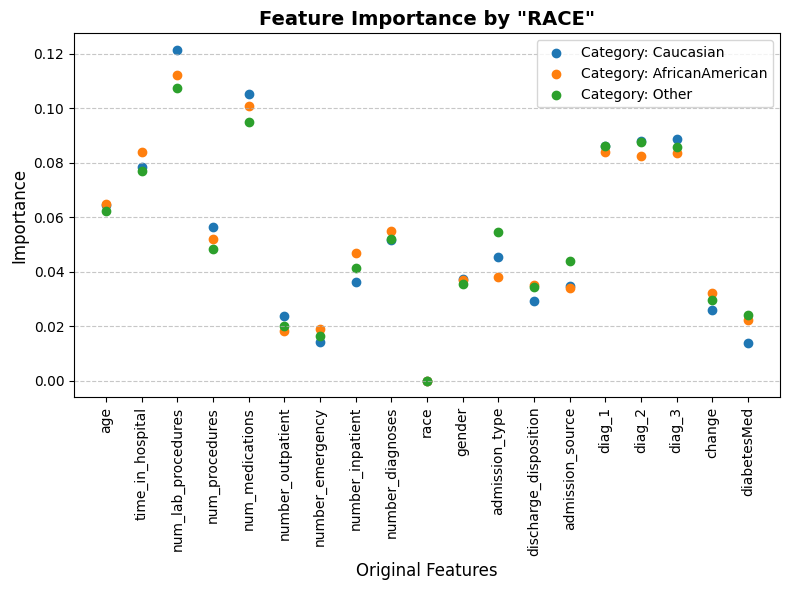

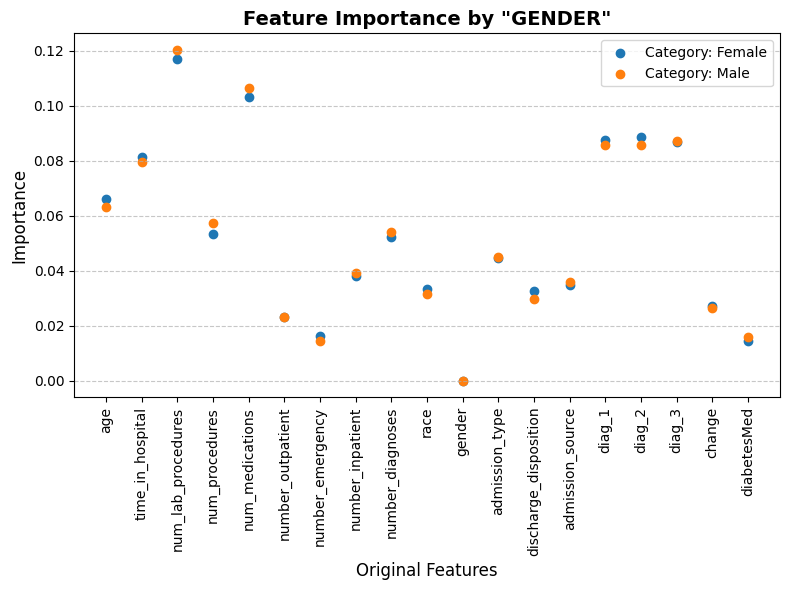

In [19]:
for sensitive in feat_sensitive:
    plt.figure(figsize=(8, 6))
    plt.title(f'Feature Importance by "{sensitive.upper()}"', fontdict={'fontsize':14, 'weight': 'bold'})

    for category, classifier in models_sensitive[sensitive].items():
        feature_importance = classifier.feature_importances_

        grouped_feature_importance = handleData.group_feature_importanceD(feature_names_encoded, feature_importance, feat_cat_encoded)

        features = list(grouped_feature_importance.keys())
        importances = [np.sum(list(inner_dict.values())) for inner_dict in grouped_feature_importance.values()]

        plt.scatter(features, importances, label=f'Category: {category}')

    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel('Original Features', fontdict={'fontsize':12})
    plt.ylabel('Importance', fontdict={'fontsize':12})
    plt.legend(loc="upper right", prop={'size':10})
    plt.tight_layout()
    plt.show()


Possible biases in deployment could be avoided by implementing `Post-processing bias mitigation` methods. In this case, we offer the Reject Option Based Classification approach [4]. There are some cases where a subset has its classification particularly close to the decision boundary. We propose a perspective for the least represented  'feat2balance' where, to deal with the uncertainty for bias, we label samples close to different decision boundaries with the positive class 

In [20]:
probabilities = model_RandomForest_1.predict_proba(feat_test)

threshold_difference = 0.2  # Threshold of probability difference between the 1st and 2nd class

# Get the least present category in feat2balance
sensitive_category = feat_test.columns[feat_test.columns.str.contains(feat2balance[0])]
sensitive_category_counts = feat_test[sensitive_category].sum(axis=0)
least_present_sensitive_category = sensitive_category_counts.idxmin()
logical_vector = (feat_test[least_present_sensitive_category] == 1).values.astype(int)

tags_pred = []
for i, probs in enumerate(probabilities):
    if logical_vector[i]== 1: # If belongs to the least represented category
        max_prob = max(probs)
        second_max_prob = sorted(probs)[-2] if len(probs) > 1 else 0.0
        if max_prob - second_max_prob <= threshold_difference:
            if positive_class:
                tags_pred.append(float(positive_class))
            else:
                tags_pred.append(1)
        else:
            tags_pred.append(model_RandomForest_1.classes_[probs.argmax()])  
    else:
        tags_pred.append(model_RandomForest_1.classes_[probs.argmax()])  

print("Random Forest (reclassification) Classification report")
print(classification_report(tags_test, tags_pred))

Random Forest (reclassification) Classification report
              precision    recall  f1-score   support

           0       0.14      0.02      0.03       532
           1       0.46      0.19      0.27      1892
           2       0.69      0.92      0.79      4598

    accuracy                           0.66      7022
   macro avg       0.43      0.38      0.36      7022
weighted avg       0.58      0.66      0.59      7022



### 3.2. Anomaly Monitoring  <a class="anchor" id="anomaly-monitoring"></a>

Diversity, non-discrimination and fairness need to be ensured during model development and once the model is deployed. Therefore, it is important to conduct `Fairness monitoring`, which could be done by implementing the same model development evaluation scheme.

## REFERENCES  <a class="anchor" id="references"></a>

1. Krasanakis, E., Spyromitros-Xioufis, E., Papadopoulos, S., & Kompatsiaris, Y. (2018). Adaptive Sensitive Reweighting to Mitigate Bias in Fairness-aware Classification. Proceedings of the 2018 World Wide Web Conference on World Wide Web - WWW ’18, 853-862. https://doi.org/10.1145/3178876.3186133 <br>

2. Rančić, S., Radovanovic, S., & Delibašić, B. (2021). Investigating Oversampling Techniques for Fair Machine Learning Models (pp. 110-123). https://doi.org/10.1007/978-3-030-73976-8_9 <br>

3. Elreedy, D., & Atiya, A. F. (2019). A Comprehensive Analysis of Synthetic Minority Oversampling Technique (SMOTE) for handling class imbalance. Information Sciences, 505, 32-64. https://doi.org/10.1016/j.ins.2019.07.070 <br>

4. Kamiran, F., Mansha, S., Karim, A., & Zhang, X. (2018). Exploiting reject option in classification for social discrimination control. Information Sciences, 425, 18-33. https://doi.org/10.1016/j.ins.2017.09.064 <br>